<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/5_mpls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 5.1.2 Activation Functions

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.9 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


#### ReLU Function

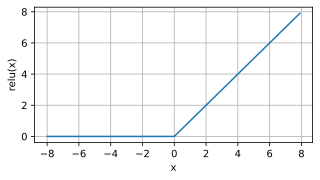

In [3]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)                                     # y = max(0, x)

d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

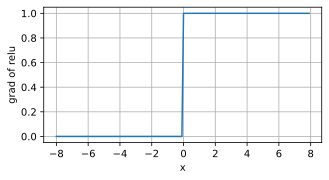

In [4]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

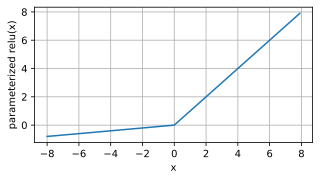

In [5]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.prelu(x, weight=torch.tensor(0.1))          # y = max(0, x) + weight*min(0, x)

d2l.plot(x.detach(), y.detach(), 'x', 'parameterized relu(x)', figsize=(5, 2.5))

#### Sigmoid Function

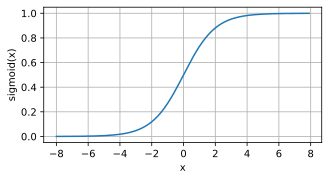

In [6]:
y = torch.sigmoid(x)

d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

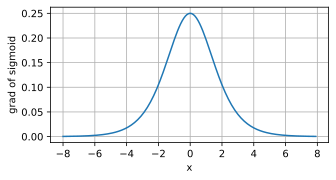

In [7]:
# x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)

d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

#### Tanh Function

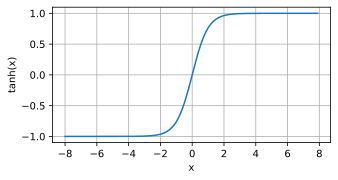

In [8]:
y = torch.tanh(x)

d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

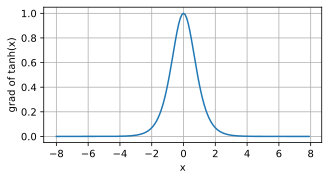

In [9]:
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)

d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh(x)', figsize=(5,2.5))

## 5.2 Implementation of Multilayer Perceptrons

In [10]:
from torch import nn

### 5.2.1 Implementation from Scratch

#### Initializing Model Parameters

In [11]:
class MLPScratch(d2l.Classifier):
  def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
    self.b1 = nn.Parameter(torch.zeros(num_hiddens))
    self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
    self.b2 = nn.Parameter(torch.zeros(num_outputs))

#### Model

In [12]:
def relu(X):
  a = torch.zeros_like(X)
  return torch.max(X, a)

In [13]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
  X = X.reshape((-1, self.num_inputs))           #              (1 x 784)
  H = relu(torch.matmul(X, self.W1) + self.b1)   # X x W1 + b1  (1 x 784) X (784 x 256) + 256
  return torch.matmul(H, self.W2) + self.b2      # H x W2 + b2  (1 x 256) X (256 x 10) + 10

#### Training

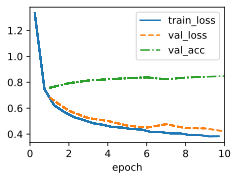

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

### 5.2.2 Concise Implementation

#### Model

In [14]:
class MLP(d2l.Classifier):
  def __init__(self, num_outputs, num_hiddens, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                             nn.ReLU(), nn.LazyLinear(num_outputs))

#### Training

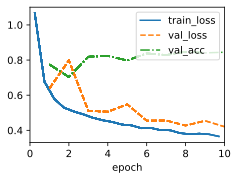

In [ ]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

## 5.4 Numerical Stability and Initialization
### 5.4.1 Vanishing and Exploding Gradients
#### Vanishing Gradients

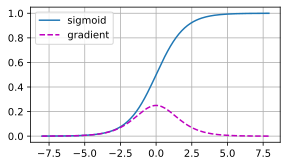

In [15]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

#### Exploding Gradients

In [16]:
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n', M)

for i in range(100):
  M = M @ torch.normal(0, 1, size=(4, 4))

print('after multiplying 100 matrices \n', M)

a single matrix 
 tensor([[-0.7386, -2.1098,  1.5467,  0.9404],
        [-0.1897,  0.6413, -2.0694,  1.2637],
        [ 1.2723, -0.7933, -1.1127, -0.7338],
        [ 1.1419,  0.9430,  0.4573, -0.2236]])
after multiplying 100 matrices 
 tensor([[ 7.0021e+25,  2.2829e+25, -2.9543e+25, -1.1268e+26],
        [ 1.1933e+26,  3.8905e+25, -5.0348e+25, -1.9203e+26],
        [-3.2462e+25, -1.0583e+25,  1.3696e+25,  5.2237e+25],
        [-2.7972e+25, -9.1195e+24,  1.1802e+25,  4.5012e+25]])


## 5.6 Dropout
### 5.6.2 Implementation from Scratch

In [18]:
import torch
from torch import nn
from d2l import torch as d2l

In [19]:
def dropout_layer(X, dropout):
  assert 0 <= dropout <= 1, 'The drop out should be between zero and one'
  
  if dropout == 1:
    return torch.zeros_like(X)
  mask = (torch.rand(X.shape) > dropout).float()
  return mask * X / (1 - dropout)                                    # Normalization


In [23]:
X = torch.arange(16, dtype=torch.float).reshape((2, 8))

print('dropout_p = 0: ', dropout_layer(X, 0))
print('dropout_p = 0.5: ', dropout_layer(X, 0.5))
print('dropout_p = 1: ', dropout_layer(X, 1))

dropout_p = 0:  tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5:  tensor([[ 0.,  2.,  4.,  0.,  8.,  0.,  0.,  0.],
        [ 0., 18., 20., 22., 24., 26.,  0.,  0.]])
dropout_p = 1:  tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


#### Defining the Model

In [24]:
class DropoutMLPScratch(d2l.Classifier):
  def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
               dropout_1, dropout_2, lr):
    super().__init__()
    self.save_hyperparameters()
    self.lin1 = nn.LazyLinear(num_hiddens_1)
    self.lin2 = nn.LazyLinear(num_hiddens_2)
    self.lin3 = nn.LazyLinear(num_outputs)
    self.relu = nn.ReLU()

  def forward(self, X):
    H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
    if self.training:
      H1 = dropout_layer(H1, self.dropout_1)
    H2 = self.relu(self.lin2(H1))
    if self.training:
      H2 = dropout_layer(H2, self.dropout_2)
    return self.lin3(H2)

#### Training

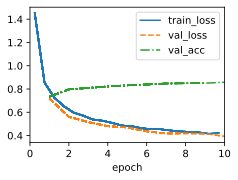

In [27]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}

model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

### 5.6.3 Concise Implementation

In [30]:
class DropoutMLP(d2l.Classifier):
  def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
               dropout_1, dropout_2, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
        nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
        nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

#### Training

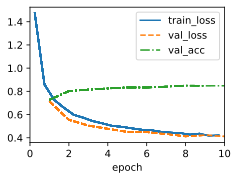

In [31]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)

## 5.7 Predicting House Prices on Kaggle
### 5.7.1 Downloading Data

In [32]:
import hashlib
import os
import tarfile
import zipfile
import requests


In [42]:
def download(url, folder='../data', sha1_hash=None):
  """Download a file to folder and return the local filepath."""
  if not url.startswith('http'):
    # for back compatability
    url, sha1_hash = d2l.DATA_HUB[url]
  os.makedirs(folder, exist_ok=True)
  fname = os.path.join(folder, url.split('/')[-1])
  # Check if hit cache
  if os.path.exists(fname) and sha1_hash:
    sha1 = hashlib.sha1()
    with open(fname, 'rb') as f:
      while True:
        data = f.read(1048576)
        if not data:
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname
  # Download
  print(f'Downloading {fname} from {url}...')
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

In [43]:
def extract(filename, folder=None):
  """Extract a zip/tar file into folder"""
  base_dir = os.path.dirname(filename)
  _, ext = os.path.splitext(filename)
  assert ext in ('.zip', '.tar', '.gz'), 'Only support zip/tar files.'
  if ext == '.zip':
    fp = zipfile.ZipFile(filename, 'r')
  else:
    fp = tarfile.open(filename, 'r')
  if folder is None:
    folder = base_dir
  fp.extractall(folder)

### 5.7.3 Accessing and Reading the Dataset

In [44]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [45]:
class KaggleHouse(d2l.DataModule):
  def __init__(self, batch_size, train=None, val=None):
    super().__init__()
    self.save_hyperparameters()
    if self.train is None:
      self.raw_train = pd.read_csv(download(
          d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
          sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
      self.raw_val = pd.read_csv(download(
          d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
          sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [47]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


### 5.7.4 Data Preprocessing

In [49]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [52]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
  # Remove the ID and label columns
  label = 'SalePrice'
  features = pd.concat(
      (self.raw_train.drop(columns=['Id', label]),
       self.raw_val.drop(columns=['Id'])))
  
  # Standardize numerical columns
  numeric_features = features.dtypes[features.dtypes != 'object'].index
  features[numeric_features] = features[numeric_features].apply(
      lambda x: (x - x.mean()) / (x.std()))
  
  # Replace NAN numerical features by 0
  features[numeric_features] = features[numeric_features].fillna(0)

  # Replace discrete features by one-hot encoding
  features = pd.get_dummies(features, dummy_na=True)

  # Save preprocessed features
  self.train = features[:self.raw_train.shape[0]].copy()
  self.train[label] = self.raw_train[label]
  self.val = features[self.raw_train.shape[0]:].copy()

In [53]:
data.preprocess()
data.train.shape

(1460, 332)